# Sparse coding with a precomputed dictionary

신호를 Ricker wavelet의 희소 집합으로 변환한다.
이 예제는 SparseCoder estimator를 사용하여 다양한 희소 부호화 방법을 시각적으로 비교한다.
Ricker는 piecewise constant 신호를 잘 나타내지 못하는 커널이다.
다른 wavelet의 폭을 추가하는 것이 얼마나 중요한지 알 수 있다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import SparseCoder

In [2]:
def ricker_function(resolution, center, width):
    """이산 하위 샘플링된 Ricker (Mexican hat) wavelets"""
    x = np.linspace(0, resolution - 1, resolution)
    x = (
        (2 / (np.sqrt(3 * width) * np.pi**0.25))
        * (1 - (x - center) ** 2 / width**2)
        * np.exp(-((x - center) ** 2) / (2 * width**2))
    )
    return x

In [3]:
def ricker_matrix(width, resolution, n_components):
    """Ricker (Mexican hat) wavelets의 Dictionary"""
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D**2, axis=1))[:, np.newaxis]
    return D

In [4]:
resolution = 1024
subsampling = 3  # subsampling 비율
width = 100
n_components = resolution // subsampling

# wavelet dictionary 계산한다.
D_fixed = ricker_matrix(width=width, resolution=resolution, n_components=n_components)
D_multi = np.r_[
    tuple(
        ricker_matrix(width=w, resolution=resolution, n_components=n_components // 5)
        for w in (10, 50, 100, 500, 1000)
    )
]

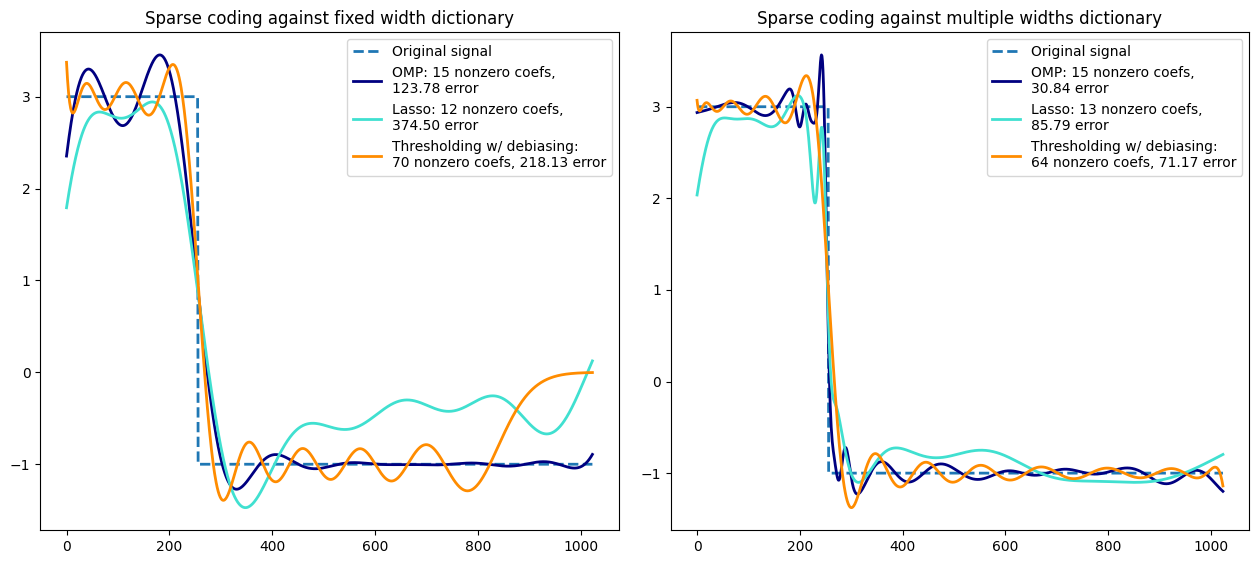

In [7]:
# 신호를 생성한다.
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3.0
y[np.logical_not(first_quarter)] = -1.0

# 다양한 희소 부호화 방법을 다음 형식으로 나열한다.:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)
estimators = [
    ("OMP", "omp", None, 15, "navy"),
    ("Lasso", "lasso_lars", 2, None, "turquoise"),
]
lw = 2

plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(
    zip((D_fixed, D_multi), ("fixed width", "multiple widths"))
):
    plt.subplot(1, 2, subplot + 1)
    plt.title("Sparse coding against %s dictionary" % title)
    plt.plot(y, lw=lw, linestyle="--", label="Original signal")
    # wavelet 추정을 한다.
    for title, algo, alpha, n_nonzero, color in estimators:
        coder = SparseCoder(
            dictionary=D,
            transform_n_nonzero_coefs=n_nonzero,
            transform_alpha=alpha,
            transform_algorithm=algo,
        )
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        plt.plot(
            x,
            color=color,
            lw=lw,
            label="%s: %s nonzero coefs,\n%.2f error" % (title, density, squared_error),
        )

            # Soft thresholding debiasing
            # soft thresholding: 규칙화 기법 중 하나로, 값이 특정 임계값보다 낮으면 0으로 만들고, 높으면 감소시키는 방식으로 신호나 데이터를 희소화하는 방법이다.
            # debiasing: 편향을 제거하는 과정 또는 기술이다.
    coder = SparseCoder(
        dictionary=D, transform_algorithm="threshold", transform_alpha=20
    )
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=None)
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    plt.plot(
        x,
        color="darkorange",
        lw=lw,
        label="Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error"
        % (len(idx), squared_error),
    )
    plt.axis("tight")
    plt.legend(shadow=False, loc="best")
plt.subplots_adjust(0.04, 0.07, 0.97, 0.90, 0.09, 0.2)
plt.show()